In [1]:
# Make sure that cuda is installed
import torch
torch.cuda.is_available()

True

In [2]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [3]:
# GPT 2 Model (124M parameters)

# 117M - Is actually 124M parameters due to the original paper counting parameters wrong
from transformers import GPT2LMHeadModel

# This will get the entire pretrained model parameters
hugginface_gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
state = hugginface_gpt2_model.state_dict()

# For all keys of the model parameters we can print their parameter weights
for key, value in state.items():
    print(key, value.shape)

# wte - weights for token embedding - 50257 tokens (50000 merges, 256 base utf8 and 1 special <|endofline|>)
# wpe - weights for positional embeddings - 1024 (max sequence length of 1024) we need positions for all of those that it can attend to
# 768 is the fixed vector length

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

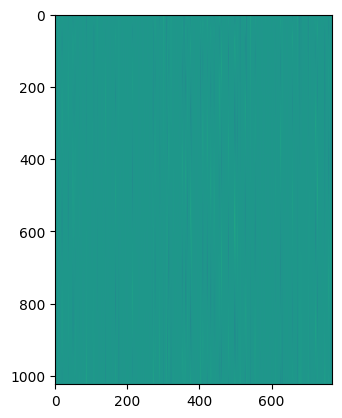

In [16]:
# torch.Size([1024, 768])
state["transformer.wpe.weight"]

import matplotlib.pyplot as plt

# We can visualise the positional embeddings
# Each row is a fixed absolute position
# Positional embeddings learn cosines and sines that represent each position
plt.imshow(state["transformer.wpe.weight"])

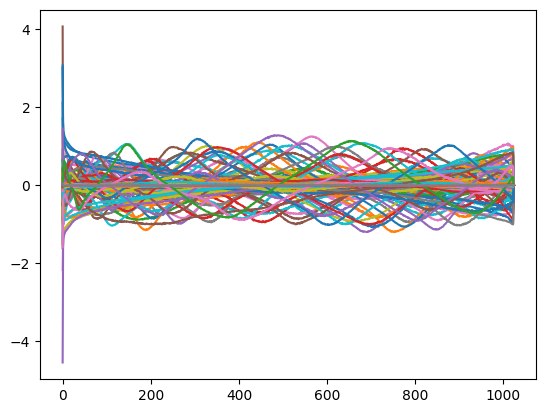

In [26]:
# If we have jagged lines then we konw that the model is not fully trained, we can take it further
# In the original transformer paper these are fixed cosines and sinusoidal waves however in GPT2 these are trained as parameters
plt.plot(state["transformer.wpe.weight"])

# plt.plot(state["transformer.wpe.weight"][:, 160])
# plt.plot(state["transformer.wpe.weight"][:, 270])
# plt.plot(state["transformer.wpe.weight"][:, 190])

In [3]:
# Figuring out the dataset we want to use

from datasets import load_dataset

ds = load_dataset("lighteval/mmlu", "anatomy")

c:\Users\diogo\Desktop\VS\ML\NNZeroToHero\GPT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating dev split: 100%|██████████| 5/5 [00:00<00:00, 2535.24 examples/s]


In [4]:
ds

DatasetDict({
    auxiliary_train: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 99842
    })
    test: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 135
    })
    validation: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 14
    })
    dev: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 5
    })
})

In [11]:
training_dataset = ds.get("auxiliary_train")


In [15]:
training_dataset.data


MemoryMappedTable
question: string
subject: string
choices: list<item: string>
  child 0, item: string
answer: int64
----
question: [["Davis decided to kill Adams. He set out for Adams's house. Before he got there he saw Brooks, who resembled Adams. Thinking that Brooks was Adams, Davis shot at Brooks. The shot missed Brooks but wounded Case, who was some distance away. Davis had not seen Case. In a prosecution under a statute that proscribes any attempt to commit murder, the district attorney should indicate that the intended victim(s) was/were","A state statute requires any person licensed to sell prescription drugs to file with the State Board of Health a report listing the types and amounts of such drugs sold if his or her sales of such drugs exceed $50,000 during a calendar year. The statute makes it a misdemeanor to "knowingly fail to file" such a report. Nelson, who is licensed to sell prescription drugs, sold $63,000 worth of prescription drugs during 1976 but did not file the 

In [1]:
from math import cos, pi
# The decay time is less than the max steps time - it should train at 10% near the end
# They use a cosine decay learning rate scheduler down to 10% of the original learning rate value and a warmup for the first tokens
max_lr = 6e-4
min_lr = max_lr * 0.1
max_steps = 50
warmup_steps = max_steps * 0.1
# Cosine decay function
def get_lr(step):
    if step < warmup_steps:
        return max_lr * (step + 1) / warmup_steps
    if step > max_steps:
        return min_lr
    
    decay_rate = (step - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_rate <= 1
    coeff = 0.5 * (1.0 + cos(pi * decay_rate))
    return min_lr + coeff * (max_lr - min_lr)

In [3]:
from datasets import load_dataset
fw = load_dataset("HuggingFaceFW/fineweb-edu", name="sample-10BT", split="train")

In [4]:
# We can get the next in the dataset if we have streaming mode as true
# print(next(iter(fw)))
# print(fw)
fw

Dataset({
    features: ['text', 'id', 'dump', 'url', 'file_path', 'language', 'language_score', 'token_count', 'score', 'int_score'],
    num_rows: 9672101
})

In [10]:
import tiktoken

# Initial dataloader implementation for a basic text file dataset
class Dataloader:
    # TODO research what would happen if we just got a randomly chosen part of the dataset that is large enough since this one is limited

    def __init__(self, B, T):
        self.B = B
        self.T = T
        self.batch_size = B*T

        # TODO update this with the tokeniser implementation
        encoding = tiktoken.get_encoding("gpt2")
        with open("Pre Train Datasets/input.txt", "r") as dataset:
            text = dataset.read()

        # Tokens here may have to be taken to the device
        self.tokens = torch.tensor(encoding.encode(text))
        self.total_tokens = len(self.tokens)


        # Keep track of where in our data have previously loaded things
        self.position = 0

    def next_batch(self):
        B, T = self.B, self.T

        # We want our buffer to include the extra character so that we can easily get our targets using .view()
        # Once you cast any tensor to your device any following tensors that are using .view() will be within that device too
        dataset_buffer = self.tokens[self.position:self.position + (self.batch_size) + 1]
        x = dataset_buffer[:-1].view(B, T)
        targets = dataset_buffer[1:].view(B, T)

        # Update our position within the dataset, unless if that new position does not have enough data for another batch
        self.position += self.batch_size
        if self.position + (self.batch_size + 1) > self.total_tokens:
            self.position = 0

        return x, targets

In [5]:
# encoding = tiktoken.get_encoding("gpt2")
# with open("Pre Train Datasets/input.txt", "r") as dataset:
#     text = dataset.read()

In [6]:
import os 

In [19]:
data_root = "edu_fineweb10B"
shards = os.listdir(data_root)
shards = [shard for shard in shards if "train" in shard]

In [17]:
shards

['edufineweb_train_000001.npy',
 'edufineweb_train_000002.npy',
 'edufineweb_train_000003.npy',
 'edufineweb_train_000004.npy',
 'edufineweb_train_000005.npy',
 'edufineweb_train_000006.npy',
 'edufineweb_train_000007.npy',
 'edufineweb_train_000008.npy',
 'edufineweb_train_000009.npy',
 'edufineweb_train_000010.npy',
 'edufineweb_train_000011.npy',
 'edufineweb_train_000012.npy',
 'edufineweb_train_000013.npy',
 'edufineweb_train_000014.npy',
 'edufineweb_train_000015.npy',
 'edufineweb_train_000016.npy',
 'edufineweb_train_000017.npy',
 'edufineweb_train_000018.npy',
 'edufineweb_train_000019.npy',
 'edufineweb_train_000020.npy',
 'edufineweb_train_000021.npy',
 'edufineweb_train_000022.npy',
 'edufineweb_train_000023.npy',
 'edufineweb_train_000024.npy',
 'edufineweb_train_000025.npy',
 'edufineweb_train_000026.npy',
 'edufineweb_train_000027.npy',
 'edufineweb_train_000028.npy',
 'edufineweb_train_000029.npy',
 'edufineweb_train_000030.npy',
 'edufineweb_train_000031.npy',
 'edufin

In [18]:
"train" in 'edufineweb_train_000099.npy'

True